In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import svm,cluster
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix 
import six
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier as DT

stroke_data = pd.read_csv("/content/sample_data/healthcare-dataset-stroke-data.csv")

Exploratory analysis

In [ ]:
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
stroke_data.describe(include='all')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,36517.829354,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,21161.721625,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17741.250000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,36932.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,54682.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


In [ ]:
#Checking for missing values
print(stroke_data.isnull().any())
#So bmi values has Nan 
print('\n Number of Nan in bmi feature: {}'.format(stroke_data['bmi'].isnull().sum()))


id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

 Number of Nan in bmi feature: 201


In [ ]:
#Checing the datatypes of each column
stroke_data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

###Out of 9 columns (excluding id and stroke) Age, avergae glucose level and bmi are features with continuous values

Casting hypertension and heart disease to object, for chi-squared analysis

In [ ]:
stroke_copy = stroke_data.copy(deep=True)
stroke_copy['hypertension'] = np.where(stroke_copy.hypertension == 1, 'Yes', 'No')
stroke_copy['heart_disease'] = np.where(stroke_copy.heart_disease == 1, 'Yes', 'No')

In [ ]:
# Chi-squared stats for hypertension and heart disease
def chi_test(f1,f2):
  tab = pd.crosstab(stroke_copy[f1],stroke_copy[f2])
  ov_hyp_heart = tab.values
  ex_hyp_heart = stats.chi2_contingency(ov_hyp_heart)
  ex_hyp_heart = ex_hyp_heart[3]
  no_of_rows=len(tab.iloc[0:2,0])
  no_of_columns=len(tab.iloc[0,0:2])
  ddf = (no_of_rows-1)*(no_of_columns-1)
  stat,p = stats.chisquare(ov_hyp_heart.ravel(),ex_hyp_heart.ravel(),ddof=ddf)
  alpha = 0.005
  if p<=alpha:
    return True
  else:
    return False
  



In [ ]:
for i in ['gender','hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type','smoking_status']:
  j = 'stroke'
  if chi_test(i,j) is True:
    print('The fearure stroke is dependent on {}'.format(i))

The fearure stroke is dependent on hypertension
The fearure stroke is dependent on heart_disease
The fearure stroke is dependent on ever_married
The fearure stroke is dependent on work_type
The fearure stroke is dependent on smoking_status


##Handling NaN 

In [ ]:
mea =  stroke_copy['bmi'].mean()
stroke_copy['bmi'] = stroke_copy['bmi'].fillna(mea)
stroke_copy['bmi'].isnull().any()

False

In [ ]:
for i in ['avg_glucose_level','bmi','age']:
  j='stroke'
  cor,p = stats.pearsonr(stroke_copy[i],stroke_copy[j])
  if p<=0.05:
    print('{} and {} are correlated with a correlation value of {}'.format(i,j,cor))

avg_glucose_level and stroke are correlated with a correlation value of 0.13194544082571016
bmi and stroke are correlated with a correlation value of 0.038946596512020044
age and stroke are correlated with a correlation value of 0.24525734617097478


###Extracting only correlated features

In [ ]:
stroke_extracted_tmp = stroke_data.copy(deep=True)
stroke_extracted  = stroke_extracted_tmp[['age','bmi','hypertension','heart_disease','ever_married','work_type','smoking_status','stroke']]
mea =  stroke_extracted['bmi'].mean()
stroke_extracted['bmi']= stroke_extracted['bmi'].fillna(mea)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
stroke_extracted['ever_married_cat'] = pd.factorize(stroke_extracted['ever_married'])[0]
stroke_extracted['work_type_cat'] = pd.factorize(stroke_extracted['work_type'])[0]
stroke_extracted['smoking_status_cat'] = pd.factorize(stroke_extracted['smoking_status'])[0]
stroke_extracted_new  = stroke_extracted[['age','bmi','hypertension','heart_disease','ever_married_cat','work_type_cat','smoking_status_cat','stroke']]
stroke_x  = stroke_extracted_new[['age','bmi','hypertension','heart_disease','ever_married_cat','work_type_cat','smoking_status_cat']]
stroke_y  = stroke_extracted_new[['stroke']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

## Checking class distribution


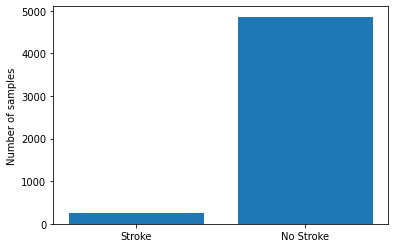

In [ ]:
stroke_count =  stroke_extracted['stroke'].sum()
x = ['Stroke','No Stroke']
y = [stroke_count,len(stroke_extracted)-stroke_count]
plt.bar(x,y)
plt.ylabel('Number of samples')
plt.show()

### Train 75% Validation 25%

In [ ]:

x_train, x_valid, y_train, y_valid = train_test_split(stroke_x, stroke_y, test_size=0.75, random_state=42)

###Training SVM and Descision Tree with unbalanced dataset

In [ ]:
#SVM
model = svm.SVC(kernel='poly',probability=True)
model.fit(x_train,y_train.squeeze())
train_predictions = model.predict(x_train)
valid_predictions = model.predict(x_valid)
print('Training accuracy is {:2f}'.format(accuracy_score(y_train,train_predictions)))
print('Training F1_score f1_score is {:2f}'.format(f1_score(y_train,train_predictions)))
print('Validation accuracy is {:2f}'.format(accuracy_score(y_valid,valid_predictions)))
print('Validation F1_score is {:2f}'.format(f1_score(y_valid,valid_predictions)))




Training accuracy is 0.949099
Training F1_score f1_score is 0.000000
Validation accuracy is 0.951996
Validation F1_score is 0.000000


In [ ]:
#Decision Tree
model = DT()
model.fit(x_train,y_train)
train_predictions = model.predict(x_train)
valid_predictions = model.predict(x_valid)
print('Training accuracy is {:2f}'.format(accuracy_score(y_train,train_predictions)))
print('Training F1_score f1_score is {:2f}'.format(f1_score(y_train,train_predictions,average='micro')))
print('Validation accuracy is {:2f}'.format(accuracy_score(y_valid,valid_predictions)))
print('Validation F1_score is {:2f}'.format(f1_score(y_valid,valid_predictions,average='micro')))

Training accuracy is 1.000000
Training F1_score f1_score is 1.000000
Validation accuracy is 0.926428
Validation F1_score is 0.926428


In [ ]:
x_train.iloc[1]

age                   40.0
bmi                   30.5
hypertension           0.0
heart_disease          0.0
ever_married_cat       0.0
work_type_cat          0.0
smoking_status_cat     3.0
Name: 4265, dtype: float64

### Addressing class imabalance with SMOTE

In [ ]:
over = SMOTE()
X_transformed, y_transformed = over.fit_resample(stroke_x,stroke_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Positive examples (stroke) with SMOTE is: {}'.format(y_transformed.sum()))
print('Positive examples (stroke) without SMOTE is: {}'.format(stroke_y.sum()))
print('Negative examples (non-stroke) with SMOTE is: {}'.format(len(y_transformed)-y_transformed.sum()))
print('Negative examples (non-stroke) without SMOTE is: {}'.format(len(stroke_y)-stroke_y.sum()))

Positive examples (stroke) with SMOTE is: 4861
Positive examples (stroke) without SMOTE is: stroke    249
dtype: int64
Negative examples (non-stroke) with SMOTE is: 4861
Negative examples (non-stroke) without SMOTE is: stroke    4861
dtype: int64


### Train 75% Validation 25%

In [ ]:
x_train_trans, x_valid_trans, y_train_trans, y_valid_trans = train_test_split(X_transformed, y_transformed, test_size=0.75, random_state=42)

## Training Decision Tree with balanced dataset

In [ ]:
#Decision Tree
model = DT()
model.fit(x_train_trans,y_train_trans)
train_predictions = model.predict(x_train_trans)
valid_predictions = model.predict(x_valid_trans)
print('Training accuracy is {:2f}'.format(accuracy_score(y_train_trans,train_predictions)))
print('Training F1_score f1_score is {:2f}'.format(f1_score(y_train_trans,train_predictions,average='micro')))
print('Validation accuracy is {:2f}'.format(accuracy_score(y_valid_trans,valid_predictions)))
print('Validation F1_score is {:2f}'.format(f1_score(y_valid_trans,valid_predictions,average='micro')))

Training accuracy is 1.000000
Training F1_score f1_score is 1.000000
Validation accuracy is 0.886588
Validation F1_score is 0.886588


In [ ]:
print('Depth of Decison Tree {}'.format(model.tree_.max_depth))

Depth of Decison Tree 18


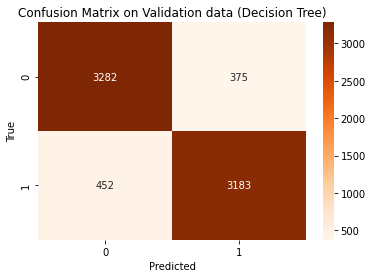

In [ ]:
cf = confusion_matrix(y_valid_trans,valid_predictions)
sns.heatmap(data=cf,cmap=plt.cm.Oranges,annot=True,fmt='d')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix on Validation data (Decision Tree)')
plt.show()

### Visualizing Decision Tree

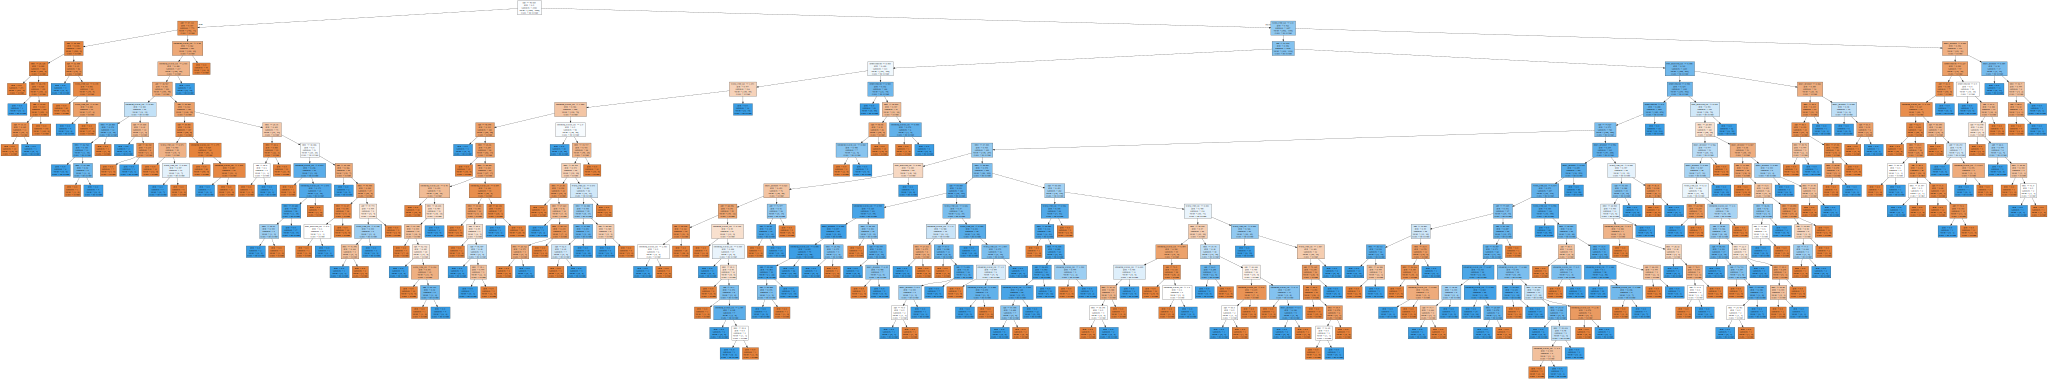

In [ ]:
import graphviz
# DOT data
feature_names = ['age','bmi','hypertension','heart_disease','ever_married_cat','work_type_cat','smoking_status_cat']
class_names = ['stroke','no stroke']
from sklearn import tree
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=feature_names,  
                                class_names=class_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph



### Addressing class imbalance with undersampling

In [ ]:
res = stroke_extracted_new.sort_values(by = 'stroke')
pos = res.iloc[4861:]
neg = res.iloc[:249]
data_us = pd.concat([pos, neg])


498


In [ ]:
stroke_x_us  = data_us[['age','bmi','hypertension','heart_disease','ever_married_cat','work_type_cat','smoking_status_cat']]
stroke_y_us  = data_us[['stroke']]
x_train_us, x_valid_us, y_train_us, y_valid_us = train_test_split(stroke_x_us, stroke_y_us, test_size=0.75, random_state=42)

,age,bmi,hypertension,heart_disease,ever_married_cat,work_type_cat,smoking_status_cat
3237,36.0,29.900000,0,0,0,0,1
203,78.0,30.800000,0,0,0,1,1
26,65.0,28.200000,0,0,0,0,0
206,81.0,23.400000,0,0,0,0,1
213,48.0,20.500000,0,0,0,0,1
...,...,...,...,...,...,...,...
61,80.0,22.200000,1,0,0,0,1
3429,62.0,27.900000,0,0,0,0,1
3494,66.0,22.700000,0,0,0,0,2
3265,61.0,29.900000,0,0,0,1,1


In [ ]:
#Decision Tree
DT_us = DT()
DT_us.fit(x_train_us,y_train_us)
train_predictions = DT_us.predict(x_train_us)
valid_predictions = DT_us.predict(x_valid_us)
print('Training accuracy is {:2f}'.format(accuracy_score(y_train_us,train_predictions)))
print('Training F1_score f1_score is {:2f}'.format(f1_score(y_train_us,train_predictions,average='micro')))
print('Validation accuracy is {:2f}'.format(accuracy_score(y_valid_us,valid_predictions)))
print('Validation F1_score is {:2f}'.format(f1_score(y_valid_us,valid_predictions,average='micro')))

Training accuracy is 1.000000
Training F1_score f1_score is 1.000000
Validation accuracy is 0.628342
Validation F1_score is 0.628342


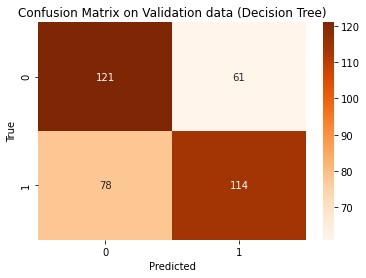

In [ ]:
cf = confusion_matrix(y_valid_us,valid_predictions)
sns.heatmap(data=cf,cmap=plt.cm.Oranges,annot=True,fmt='d')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix on Validation data (Decision Tree)')
plt.show()